In [1]:
'''
Gattiker: Demo a method for running parallel chains.

This uses the setup for the ball_drop_1 notebook example,
but will not focus on the setup, rather only the sampling.

'''

'\nGattiker: Demo a method for running parallel chains.\n\nThis uses the setup for the ball_drop_1 notebook example,\nbut will not focus on the setup, rather only the sampling.\n\n'

In [17]:
%load_ext autoreload
%autoreload 2
import os.path
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from GenDataBallDrop1 import gen_data, plot_data
from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
from sepia.SepiaPredict import SepiaEmulatorPrediction
from time import time, sleep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
#
# Set up ball-drop-1 example dataset
#
et = 0.01 # observation error
data_dict = gen_data(et)
# field data
R = data_dict['R']             # radii of balls   .1,.2,.4 (m)
h_field = data_dict['h_field'] # observed heights 5,10,15,20 (m)
y_field = data_dict['y_field'] # observed times
# sim data
sim_design = data_dict['sim_design']

R_sim = sim_design[:,0]
C_sim = sim_design[:,1]
h_sim = data_dict['h_sim']
y_sim = data_dict['y_sim']

data = SepiaData(x_sim = np.reshape(R_sim,(len(R_sim),1)),
                 t_sim = np.reshape(C_sim,(len(C_sim),1)), 
                 y_sim = y_sim, y_ind_sim = h_sim,
                 x_obs = np.reshape(R,(len(R),1)), y_obs = y_field, y_ind_obs=h_field)
data.transform_xt()
data.standardize_y()

generating data with C =  0.023873241463784306


In [19]:
data.create_K_basis(2)

# Generate D matrix with normal kernels
D_grid = h_sim # locations on which the kernels are centered
D_width = 1.5  # width of each kernel
pv = len(D_grid)
D_obs = np.zeros(shape=(data.obs_data.y_ind.shape[0],pv))
D_sim = np.zeros(shape=(data.sim_data.y_ind.shape[0],pv))
h_dense = data_dict['h_dense']
D_dense = np.zeros(shape=(h_dense.shape[0],pv))
for j in range(pv):
    D_obs[:,j] = norm.pdf(h_field, D_grid[j], D_width)
    D_sim[:,j] = norm.pdf(h_sim, D_grid[j],D_width)
    D_dense[:,j] = norm.pdf(h_dense, D_grid[j],D_width)
data.create_D_basis(D_obs=D_obs.T,D_sim=D_sim)
#
# Data setup completed
#

In [30]:
nmcmc=1000
#
# Standard mcmc reference model setup and sampling
#
model_ref = SepiaModel(data)
model_ref.tune_step_sizes(50, 20, verbose=False)
# burn in the model. This is qualitative, and needs to be assessed on trace plots
# This model is actually OK, but do 10 samples for 'burn-in'
model_ref.do_mcmc(10, prog=False)
# and discard those samples
model_ref.clear_samples()
tref=time() # timing start
model_ref.do_mcmc(nmcmc)

sleep(0.1) # This is strictly for output formatting - tqdm seems to need time to recover.
print('\nSingle-process mcmc took %f s \n'%(time()-tref), flush=True)

#
# Multiprocessing - perform the same operations with parallel chains
#
import multiprocess as mp
print('Note that the multiprocessing library is developing quickly, and may require a recent python version')
print('This example was created in v3.8')

#
# identical model setup
#
model = SepiaModel(data)                        # new model instance
model.tune_step_sizes(50, 20, verbose=False)    # optimize step sizes
model.do_mcmc(10, prog=False)                   # The same burn-in process
model.clear_samples()                           # reset the model's sample set, leaving the model state

tref0=time() # timing checkpoint

# user needs to decide how many parallel tasks to use
# It is not productive to use "virtual" or "hyperthreading" cores for this,
# so typically, divide the total number of cores reported by 2
ptasks=int(mp.cpu_count()/2)   # number of parallel jobs
# split up the mcmc loops
total_mcmc=nmcmc                    # total samples desired
each_mcmc=int(total_mcmc/ptasks)    # the number of samples desired from each worker

# define a worker function to do some mcmc and return the samples dictionary in a queue
def worker_mcmc(model,nmcmc,res):   # Worker gets a copy of the model, the number of mcmc, and a results list
    np.random.seed()                # Worker must randomize the random number generator to not get identical results
    model.do_mcmc(10, prog=False)   # should do at least one effective sample to diverge from other worker states
    model.clear_samples()           # and discard the divergence-phase samples
    model.do_mcmc(nmcmc)            # worker does the work
    res.append(model.get_samples()) # put the results in the multiprocessing shared list that was passed in

# Create a manager for shared data with the processes
manager=mp.Manager()
# and a shared list to take the results
resList=manager.list()

# It's not necessary to have the original datasets for sampling; and it could
# be a problem to have them if they're large. So, remove them from model (temporarily)
sim_data_ref=model.data.sim_data
model.data.sim_data=[]
obs_data_ref=model.data.obs_data
model.data.obs_data=[]

# Run the mcmc worker processes [could be more compact with listcomprehensions]
# First, define the processes as ptasks number of workers with appropriate arguments
procs=[]
for _ in range(ptasks):
    procs.append( mp.Process(target=worker_mcmc, args=(model,each_mcmc,resList)) )
# Start the processes
tref1=time() # timing checkpoint
for p in procs:
    p.start()
# Wait for process completion
for p in procs:
    p.join()

tref2=time() # timing checkpoint

# Add the samples to the model object (which currently has no samples)
for r in resList:
    model.add_samples(r)

model.get_last_sample_ind()

# Set the model state to the last sample inserted
model.set_model_to_sample()

model.data.sim_data=sim_data_ref
model.data.obs_data=obs_data_ref

tref3=time()

print('Multi-process worker mcmc and samples return took %f s'%(tref2-tref1))
print('              with overhead of %f s'%( (tref1-tref0) + (tref3-tref2) ) )
print('              total = %f s'%(tref3-tref0))

#
# The samples from the parallel chains are in the Sepia model object now
# Can proceed with the Sepia model object as normal
#

# Compare the trace plots for qualitative equivalence of samples
# between the "regular" model object and the model object constituted with samples

MCMC sampling: 100%|██████████| 1000/1000 [00:05<00:00, 196.42it/s]


Single-process mcmc took 5.197185 s 



Note that the multiprocessing library is developing quickly, and may require a recent python version
This example was created in v3.8


MCMC sampling: 100%|██████████| 166/166 [00:01<00:00, 148.31it/s]


Multi-process worker mcmc and samples return took 1.253161 s
              with overhead of 0.066988 s
              total = 1.320149 s


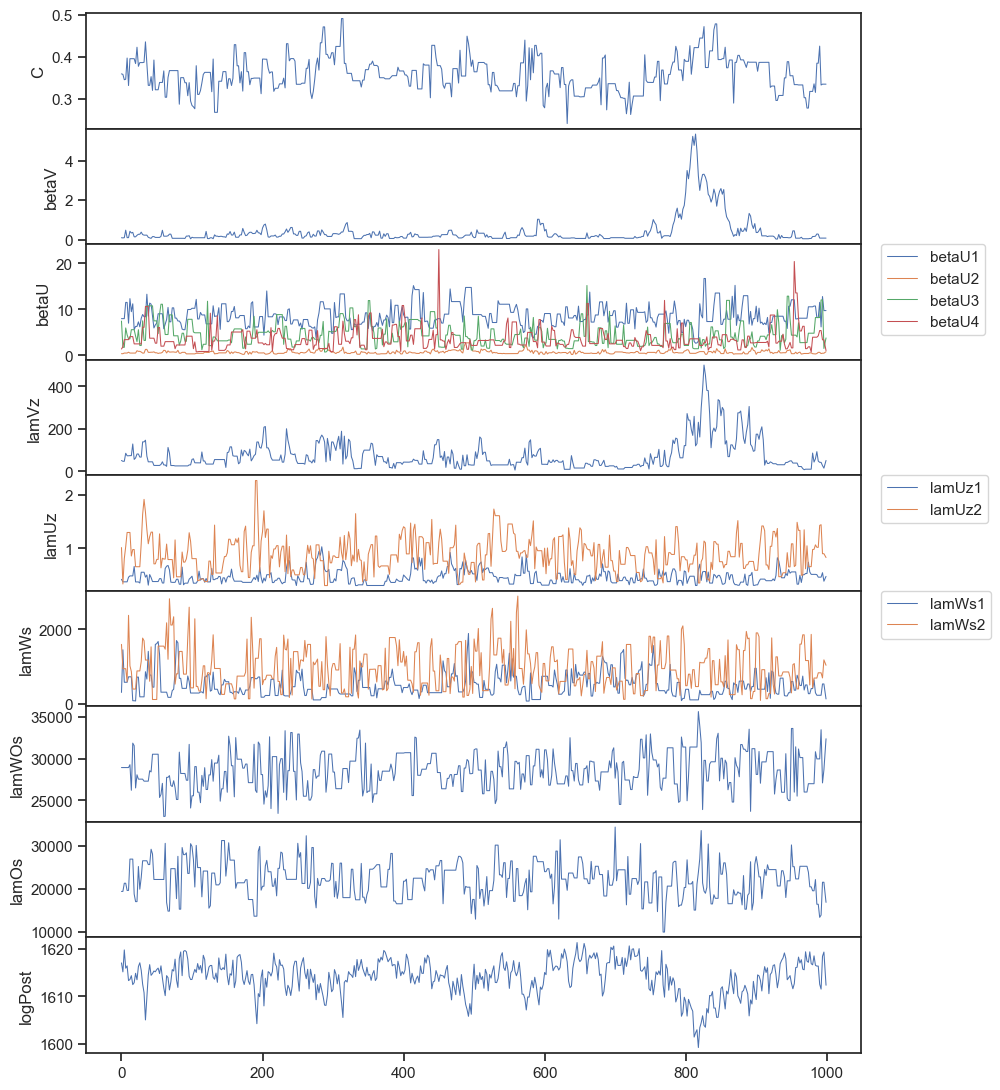

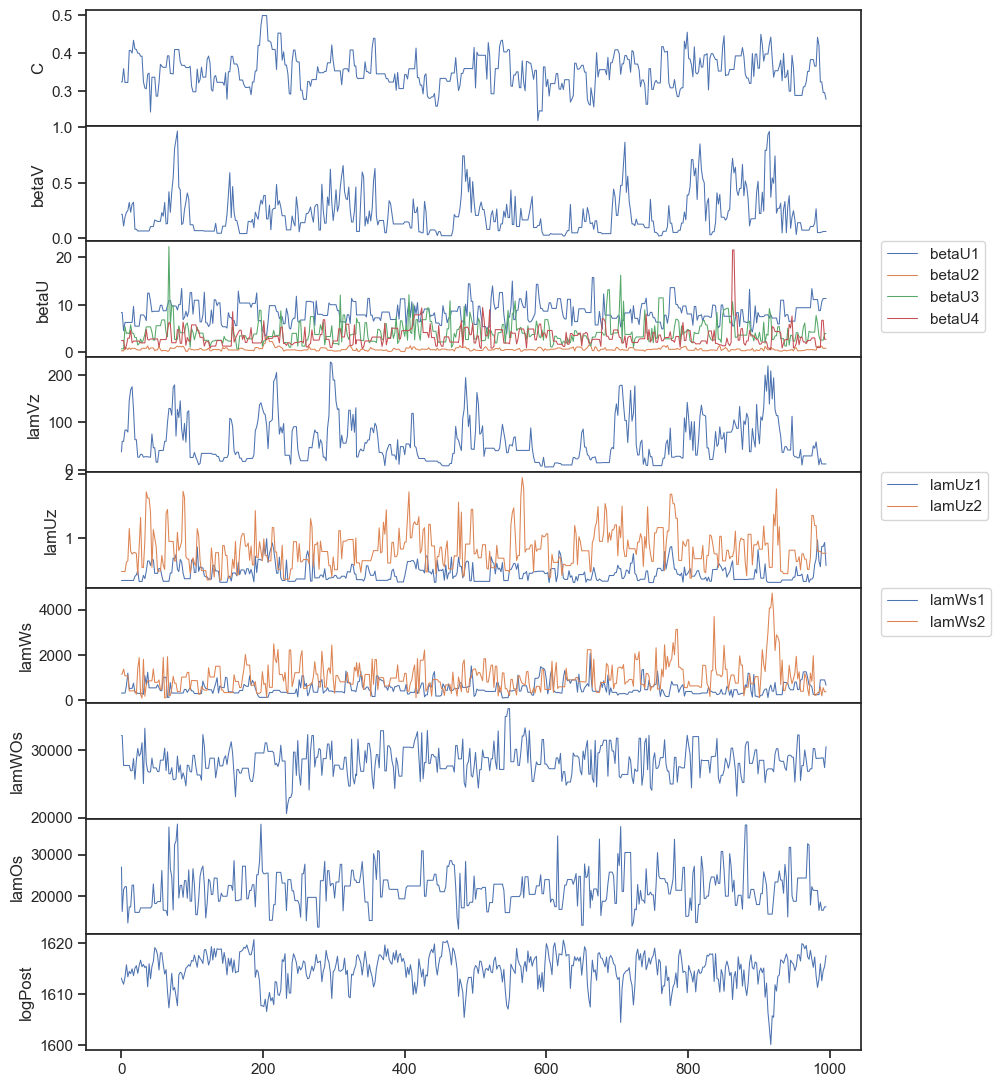

                    mean         sd  0.05 quantile  0.95 quantile
C                 0.3579     0.0404         0.2948         0.4270
betaV             0.4075     0.7328         0.0533         1.9659
betaU_1           8.6380     2.3106         5.6015        13.3578
betaU_2           0.6725     0.3553         0.2865         1.2890
betaU_3           4.6097     2.5614         1.5001         9.5082
betaU_4           3.5556     2.2867         1.1798         7.7847
lamVz            74.2177    68.0864        14.3554       210.5674
lamUz_1           0.4563     0.1270         0.3067         0.7289
lamUz_2           0.8753     0.3164         0.4044         1.4159
lamWs_1         507.1707   312.6411       115.9398      1093.8548
lamWs_2         954.5488   544.6773       189.9372      1818.4721
lamWOs        28582.4964  2168.1365     25087.4371     32315.7232
lamOs         22347.9376  4128.5828     15871.8579     29331.1452
logPost        1614.0590     3.5510      1607.3180      1619.0714
theta_nati

In [31]:
samples_dict_ref = model_ref.get_samples()
samples_dict     = model.get_samples()

theta_names = ['C']

mcmc_trace_ref = SepiaPlot.mcmc_trace(samples_dict_ref,theta_names)
mcmc_trace     = SepiaPlot.mcmc_trace(samples_dict    ,theta_names)

plt.show()

p_stats_ref = SepiaPlot.param_stats(samples_dict_ref,theta_names=theta_names,q1=.05,q2=.95,digits=4)
p_stats     = SepiaPlot.param_stats(samples_dict    ,theta_names=theta_names,q1=.05,q2=.95,digits=4)
print(p_stats_ref)
print(p_stats)

pass  # finished